In [28]:
# Cell 1: Import Libraries and Functions
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model

# Define the folder path for the images
folder_path = "resizedmaealt/"

# Define the generator and discriminator input sizes
input_size = (240, 426, 3)  # Size of the real images
output_size = (120, 208, 3)  # Size of the discriminator's output
training_input_size = (120, 208, 3)  # Size of the discriminator's input during training loop

# Function to load and preprocess the images
def load_and_preprocess_image(file_path):
    # Load the image from the file path
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image to the original size (240x426)
    img = tf.image.resize(img, input_size[:2])
    # Normalize the pixel values to the range [-1, 1]
    img = (img / 127.5) - 1.0
    return img

# Set the batch size and number of epochs
batch_size = 32
num_epochs = 1000

# Create tf.data.Dataset for loading and batching the images
image_dataset = tf.data.Dataset.list_files(folder_path + "*.jpg")
image_dataset = image_dataset.map(load_and_preprocess_image)  # Load and preprocess the images
image_dataset = image_dataset.batch(batch_size)

In [29]:

# Cell 2: Define the Generator
def build_generator(latent_dim):
    inputs = Input(shape=(latent_dim,))
    x = Dense(256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    # Adjust the output layer to match the resized size (120x208x3)
    outputs = Dense(np.prod(output_size), activation='tanh')(x)
    outputs = Reshape(output_size)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [30]:

# Cell 3: Define the Discriminator
def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [31]:
# Define the latent dimension for the generator
latent_dim = 100

# Initialize the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Function to calculate the generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Function to calculate the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Build the generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(output_size)

# Create separate optimizers for the generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Compile the generator and discriminator models
generator.compile(optimizer=generator_optimizer, loss=generator_loss)
discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

# Function to generate random latent vectors for the generator
def generate_latent_vectors(batch_size, latent_dim):
    return np.random.normal(size=(batch_size, latent_dim))


In [32]:
# Cell 4: Training Loop
for epoch in range(num_epochs):
    for batch_images in image_dataset:
        # Generate a batch of random latent vectors
        noise = generate_latent_vectors(batch_size, latent_dim)

        # Generate a batch of fake images using the generator
        generated_images = generator.predict(noise)

        # Resize real images and generated images to the discriminator's input size
        real_images_resized = tf.image.resize(batch_images, (training_input_size[0], training_input_size[1]))
        generated_images_resized = tf.image.resize(generated_images, (training_input_size[0], training_input_size[1]))

        # Concatenate real and fake images to create the input for the discriminator
        combined_images = tf.concat([real_images_resized, generated_images_resized], axis=0)

        # Create labels for the discriminator (1.0 for real images, 0.0 for fake images)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as disc_tape:
            disc_loss = discriminator_loss(discriminator(combined_images), labels)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        # Create new random latent vectors for the generator
        noise = generate_latent_vectors(batch_size, latent_dim)

        # Create labels for the generator (1, since we want the generator to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as gen_tape:
            gen_loss = generator_loss(discriminator(generator(noise)))
        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    # Print the progress every few epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")


2023-07-24 10:44:25.682327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [534]
	 [[{{node Placeholder/_0}}]]
2023-07-24 10:44:25.682590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [534]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 169ms/step


/Users/maehorak/miniconda3/envs/coding3/lib/python3.9/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 0s 34ms/step
Epoch 0, Generator Loss: 0.0005212667747400701, Discriminator Loss: 1.0039676427841187
1/1 [==============================] - 0s 33ms/step
Epoch 10, Generator Loss: 7.678136171307415e-06, Discriminator Loss: 1.003214955329895
1/1 [==============================] - 0s 33ms/step
Epoch 20, Generator Loss: 3.3090727811213583e-06, Discriminator Loss: 1.0032085180282593
1/1 [==============================] - 0s 33ms/step
Epoch 30, Generator Loss: 2.7741184567275923e-06, Discriminator Loss: 1.0032068490982056
1/1 [==============================] - 0s 34ms/step
Epoch 40, Generator Loss: 8.527754857823311e-07, Discriminator Loss: 1.0032052993774414
1/1 [==============================] - 0s 33ms/step
Epoch 50, Generator Loss: 8.668226882946328e-07, Discriminator Loss: 1.0032052993774414
1/1 [==============================] - 0s 35ms/step
Epoch 60, Generator Loss: 2.497717446203751e-07, Discriminator Loss: 1.0032049417495728
1/1 [===============

1/1 [==============================] - 0s 35ms/step


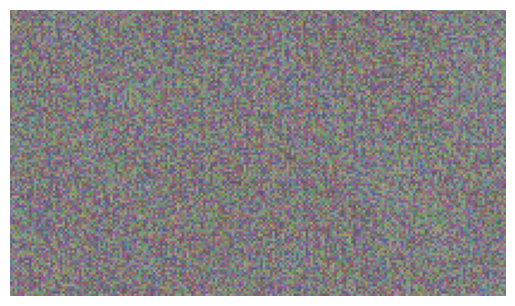

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random latent vector
latent_dim = 100
random_latent_vector = np.random.normal(size=(1, latent_dim))

# Use the generator to generate the image
generated_image = generator.predict(random_latent_vector)

# Rescale the pixel values from [-1, 1] to [0, 255]
generated_image = (generated_image + 1) * 127.5

# Convert the image to uint8 format (0 to 255)
generated_image = generated_image.astype(np.uint8)

# Display the generated image using Matplotlib
plt.imshow(generated_image[0])
plt.axis('off')
plt.show()
